# Simulation Notebook

<b>Description:</b> This notebook provides an example of how to run the simulation as well as build and test a bidding model

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.BidSimulator import BidSimulator

## Load and Preprocess CAISO Data

In [3]:
# load day-ahead and real-time prices
DAP = pd.read_csv("./data/CAISO_DAP.csv")
RTP = pd.read_csv("./data/CAISO_RTP.csv")

# read datetime and drop duplicate data
RTP["Date"] = pd.to_datetime(RTP["Date"], format="%m/%d/%Y %I:%M:%S %p")
RTP = RTP.drop_duplicates(subset=["Date", "hub"])
DAP["Date"] = pd.to_datetime(DAP["Date"], format="%m/%d/%Y %I:%M:%S %p")
DAP = DAP.drop_duplicates(subset=["Date", "zone"])

# pivot data
DAP_pivoted = DAP.pivot(index="Date", columns="zone", values="price")
RTP_pivoted = RTP.pivot(index="Date", columns="hub", values="price")

# rename 'Date' column to 'ts'
DAP_pivoted.index.names = ["ts"]
RTP_pivoted.index.names = ["ts"]

# merge dataframes on index
CAISO_PRICES = pd.merge(DAP_pivoted, RTP_pivoted, on=["ts"], how="outer")
CAISO_PRICES = CAISO_PRICES.ffill().reset_index()

In [4]:
# form datasets
PGAE_NP15 = CAISO_PRICES[["ts", "PGAE", "TH_NP15"]].rename(
    columns={"PGAE": "dap", "TH_NP15": "rtp"}
)
PGAE_ZP26 = CAISO_PRICES[["ts", "PGAE", "TH_ZP26"]].rename(
    columns={"PGAE": "dap", "TH_ZP26": "rtp"}
)
SCE_SP15 = CAISO_PRICES[["ts", "SCE", "TH_SP15"]].rename(
    columns={"SCE": "dap", "TH_SP15": "rtp"}
)
SDGE_SP15 = CAISO_PRICES[["ts", "SDGE", "TH_SP15"]].rename(
    columns={"SDGE": "dap", "TH_SP15": "rtp"}
)

## Build a BidSimulator Object

In [5]:
example_bidder = BidSimulator(
    data=PGAE_NP15,
    lookback_periods=12 * 24 * 5,  # start after first 5 days
    end=10000,
    eff=0.8,
    discharge_cost=0.0,
    initial_soc=0.5,
    capacity=8.0,
    power_max=2.0,
    resting_draw=0.00,
    timestep=(5.0 / 60),
    params=None,
)

print(example_bidder)

Bid Summary
	SOC: 0.5
	Profit: 0
	Timestamp: 1440/144457
	Capacity: 8.0
	Maximum Power: 2.0
	Efficiency: 0.8
	Discharge Cost: 0.0
	Resting Draw: 0.0


## Run Simulation Loop for Simple Bid Algorithm

Text(0, 0.5, 'Cumulative Profit ($)')

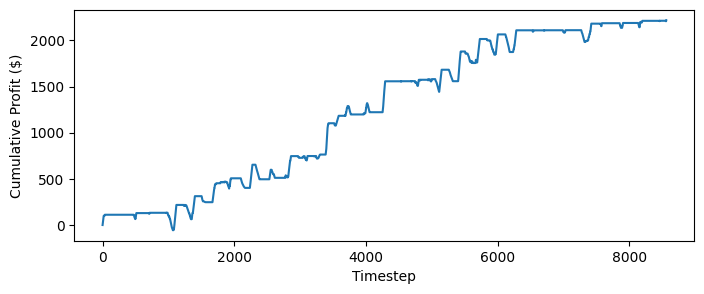

In [6]:
# get starting state and calculate price mean from the previous 5 days
example_bidder.reset_simulation()
soc, running_profit, done, lookback = example_bidder.get_state()
bid_threshold = lookback.rtp.median()
tolerance = 4
action_range = example_bidder.get_action()
steps = 0

# loop until end of data is found
while not done:
    steps += 1
    price = lookback.rtp.iloc[-1]
    bid = 0
    if price < bid_threshold - tolerance:
        bid = action_range[1]
    elif price > bid_threshold + tolerance:
        bid = action_range[0]

    soc, profit, action_range, done, lookback = example_bidder.step(bid)

# get summary statistics
final_info = example_bidder.get_summary()

# plot cumulative profit over time
plt.figure(figsize=(8, 3))
plt.plot(np.cumsum(final_info["profit_history"]))
plt.xlabel("Timestep")
plt.ylabel("Cumulative Profit ($)")